**Mounting The Drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing the dependency named sdv.**

In [ ]:
#!pip install sdv

**Importing the necessary libraries.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from collections import Counter
from math import comb
import time
import warnings
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

The McNemar test is a statistical test used to analyze paired, dichotomous data to determine if there's a statistically significant difference in the proportions of two related groups.

It's particularly useful in pre-post studies, matched case-control studies, or when comparing the performance of two classifiers.

Here used to compare the SVM and Soft Voting.

How it works:
1. Data collection:
Gather paired data where each observation has two measurements on a dichotomous variable.
2. Create a 2x2 table:
Organize the data into a table showing the frequency of each combination of outcomes (e.g., yes/yes, yes/no, no/yes, no/no).
3. Calculate the test statistic:
The McNemar test statistic, often using a chi-square approximation, is calculated based on the number of discordant pairs (where the two measurements differ).
4. Determine the p-value:
The p-value, the probability of observing such a difference if the null hypothesis is true, is calculated.
5. Interpret the results:
If the p-value is below a chosen significance level (e.g., 0.05), the null hypothesis is rejected, suggesting a statistically significant difference between the proportions.

In [ ]:
# Manual McNemar's test implementation
def manual_mcnemar(y_true, y_pred1, y_pred2):
    a = sum((y_pred1 == y_true) & (y_pred2 == y_true))
    b = sum((y_pred1 == y_true) & (y_pred2 != y_true))
    c = sum((y_pred1 != y_true) & (y_pred2 == y_true))
    d = sum((y_pred1 != y_true) & (y_pred2 != y_true))
    n = b + c
    if n == 0:
        return 1.0
    k = min(b, c)
    p_value = 2 * sum(comb(n, i) * (0.5 ** n) for i in range(k, n + 1))
    return min(p_value, 1.0)

A bootstrap confidence interval is a method for constructing a confidence interval by repeatedly resampling from the original data with replacement, creating a distribution of bootstrap samples. This distribution can then be used to estimate the uncertainty in a statistic of interest, such as a mean or median.

How it works:

1. Resampling:
The bootstrap method involves drawing multiple samples with replacement from the original dataset. This means that each data point in the original sample can be selected multiple times in a resample, and some data points might not be selected at all.
Each resample is the same size as the original sample.

2. Calculating the Statistic:
For each resample, a statistic of interest (e.g., the mean, median, standard deviation) is calculated.

3. Creating the Bootstrap Distribution:
By repeating steps 1 and 2 many times (e.g., 1000 or 10,000 times), a distribution of the statistic is created. This distribution is called the bootstrap distribution.

4. Constructing the Confidence Interval:
The bootstrap distribution can then be used to construct a confidence interval.
For example, a 95% confidence interval can be obtained by finding the 2.5th and 97.5th percentiles of the bootstrap distribution.

5. Interpretation:
The bootstrap confidence interval provides an estimate of

*   the range within which the true population parameter is likely to fall, with a certain level of confidence (e.g., 95%).
*   If the bootstrap distribution is approximately symmetric, the 95% confidence interval can be obtained by finding the values that leave 2.5% of the distribution in each tail.

Advantages of Bootstrapping:

No assumptions about the population distribution:
Bootstrapping does not require assumptions about the shape of the population distribution, unlike some traditional statistical methods.

Versatile:

Bootstrapping can be used to estimate confidence intervals for various statistics, including those for which no closed-form solutions exist.

Computer-intensive:

Bootstrapping is a computationally intensive method, but it can be implemented using software and is often used in cases where traditional statistical methods are not appropriate.

In [ ]:
# Bootstrap confidence intervals
def bootstrap_ci(y_true, y_pred, metric_func, n_bootstraps=1000, ci=0.95):
    np.random.seed(42)
    bootstrapped_scores = []
    y_true = np.array(y_true)  # Convert to numpy array
    y_pred = np.array(y_pred)  # Convert to numpy array
    n = len(y_true)
    for _ in range(n_bootstraps):
        indices = np.random.randint(0, n, n)
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    lower = sorted_scores[int((1 - ci) / 2 * len(sorted_scores))]
    upper = sorted_scores[int((ci + (1 - ci) / 2) * len(sorted_scores))]
    return lower, upper

**Loading the Data and Doing the Initial Exploration.**

In [ ]:
# [Step 1] Data Loading and Initial Exploration
data = pd.read_csv('/content/drive/MyDrive/ML Projects/Parkinsson disease.csv')
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
data.drop('name', axis=1, inplace=True)

In [ ]:
data.head()

,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,MDVPShimmer,MDVPShimmerdB,...,ShimmerDDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
data.shape

(195, 23)

In [ ]:
data.describe()

,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,MDVPShimmer,MDVPShimmerdB,...,ShimmerDDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [ ]:
print(data.isnull().sum())

MDVPFoHz         0
MDVPFhiHz        0
MDVPFloHz        0
MDVPJitter       0
MDVPJitterAbs    0
MDVPRAP          0
MDVPPPQ          0
JitterDDP        0
MDVPShimmer      0
MDVPShimmerdB    0
ShimmerAPQ3      0
ShimmerAPQ5      0
MDVPAPQ          0
ShimmerDDA       0
NHR              0
HNR              0
status           0
RPDE             0
DFA              0
spread1          0
spread2          0
D2               0
PPE              0
dtype: int64


In [ ]:
duplicate_rows = data[data.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [MDVPFoHz, MDVPFhiHz, MDVPFloHz, MDVPJitter, MDVPJitterAbs, MDVPRAP, MDVPPPQ, JitterDDP, MDVPShimmer, MDVPShimmerdB, ShimmerAPQ3, ShimmerAPQ5, MDVPAPQ, ShimmerDDA, NHR, HNR, status, RPDE, DFA, spread1, spread2, D2, PPE]
Index: []

[0 rows x 23 columns]


**Visualizing the Features Distribution.**

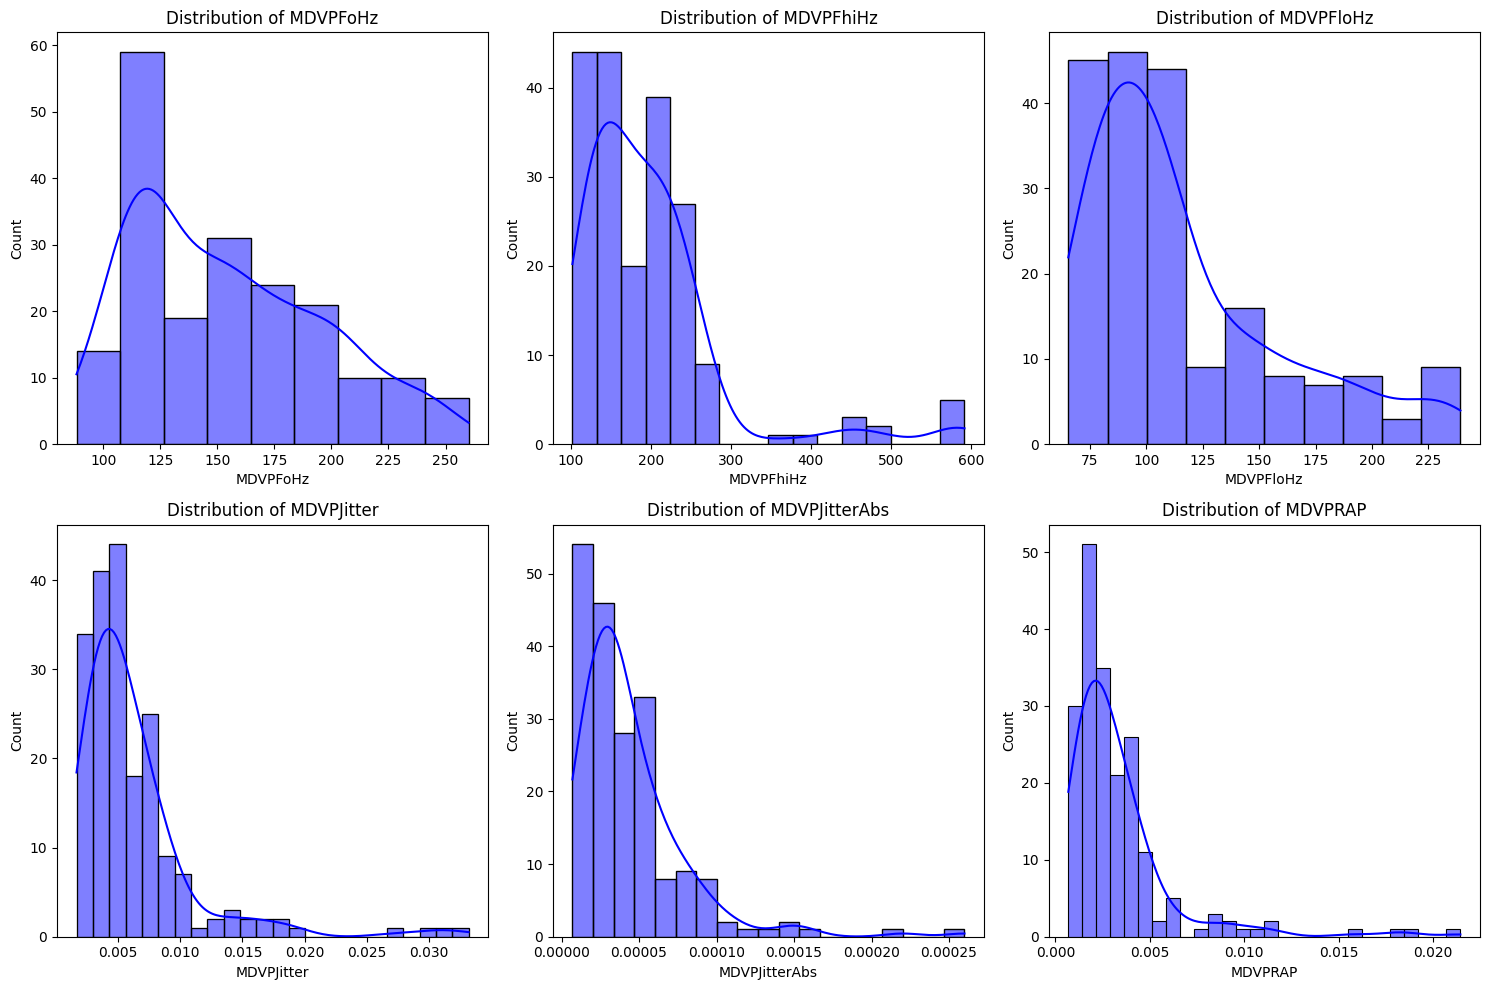

In [ ]:
# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.drop('status', axis=1).columns[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[col], kde=True, color='blue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

**Target Class Distribution**

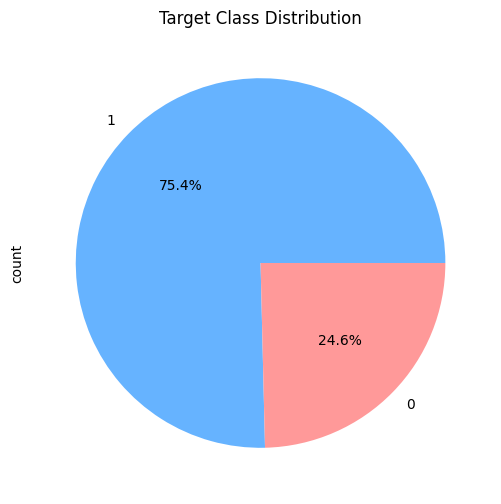

In [ ]:
# Visualize target imbalance
plt.figure(figsize=(6, 6))
data['status'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title('Target Class Distribution')
plt.show()

**Doing the Preprocessing and Feature Engineering.**

In [ ]:
# [Step 2] Preprocessing and Balancing
X = data.drop(columns=['status'])
y = data['status']

In [ ]:
# Handle missing values
X.fillna(X.mean(), inplace=True)

**Applied StandardScaler to Standardize the features.**

In [ ]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

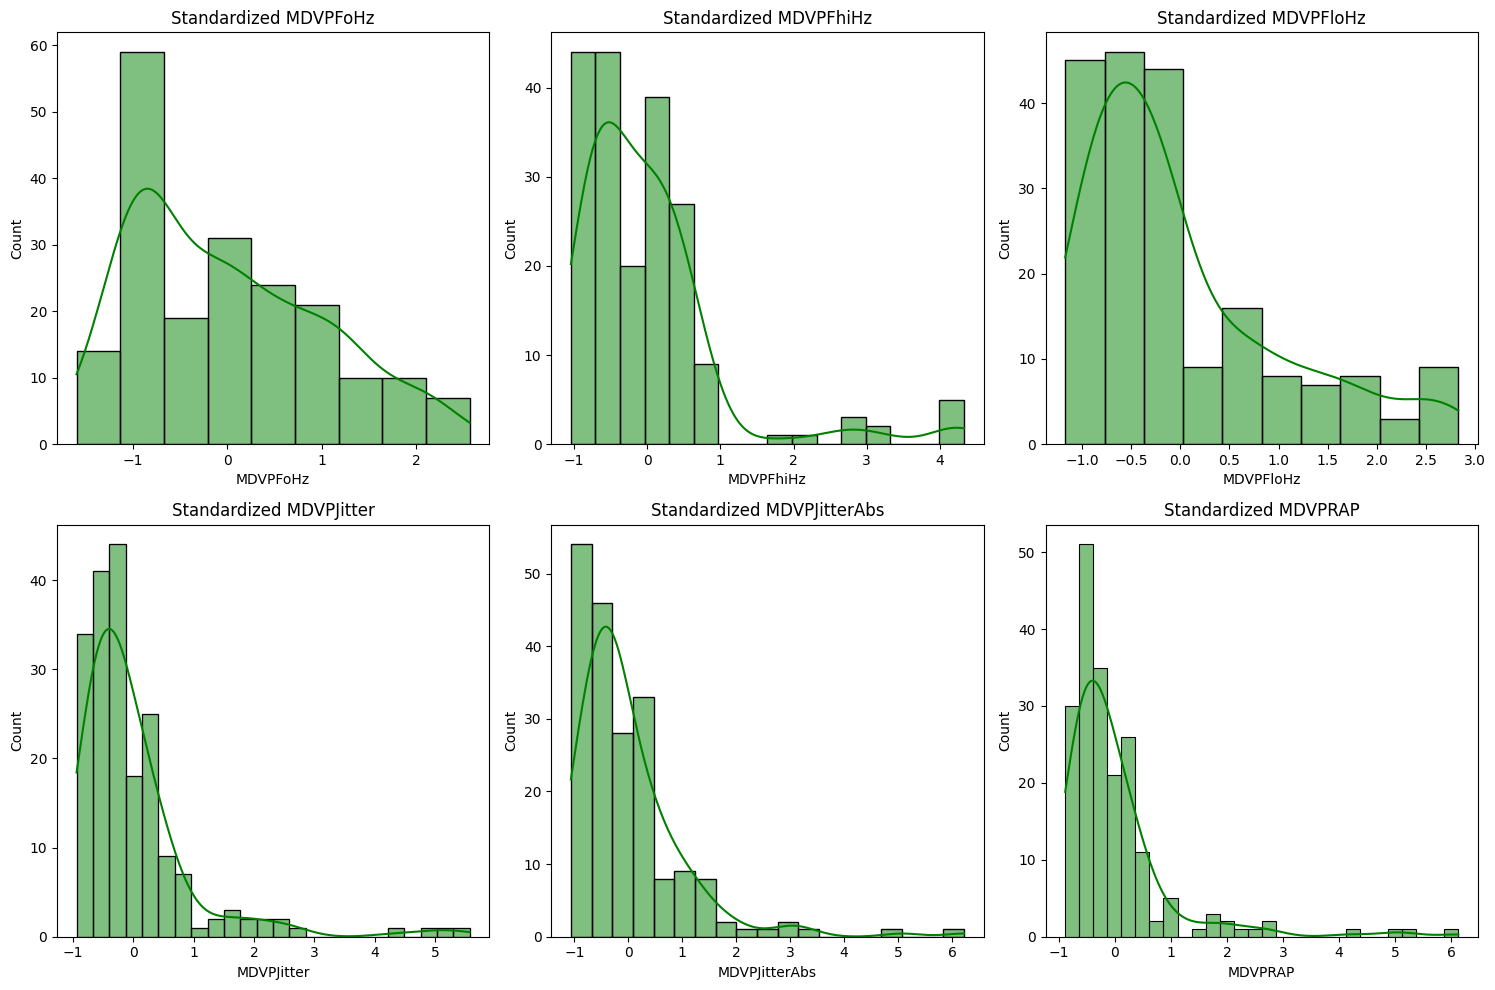

In [ ]:
# Visualize standardized features
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(X[col], kde=True, color='green')
    plt.title(f'Standardized {col}')
plt.tight_layout()
plt.show()

**Applying SMOTE to handle the target class imbalance.**

In [ ]:
# Apply SMOTE
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Original target distribution: {Counter(y)}")
print(f"After SMOTE target distribution: {Counter(y_resampled)}")

Original target distribution: Counter({1: 147, 0: 48})
After SMOTE target distribution: Counter({1: 147, 0: 117})


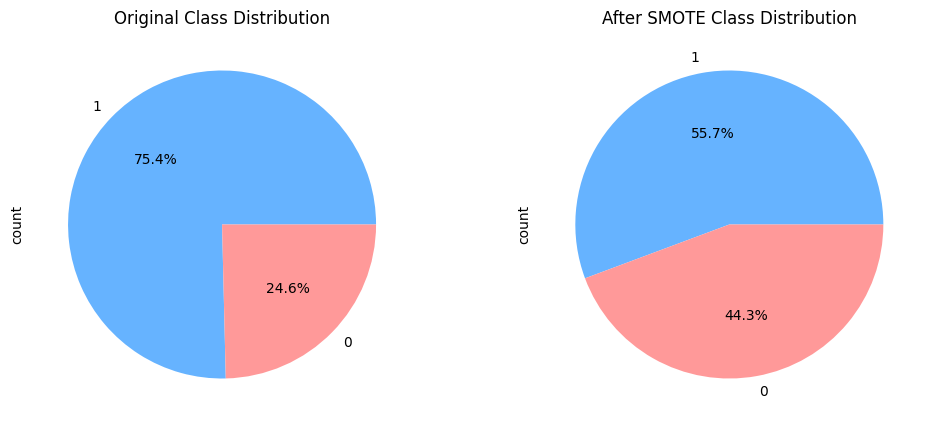

In [ ]:
# Pie charts for class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
pd.Series(y).value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1, colors=['#66b3ff', '#ff9999'])
ax1.set_title('Original Class Distribution')
pd.Series(y_resampled).value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2, colors=['#66b3ff', '#ff9999'])
ax2.set_title('After SMOTE Class Distribution')
plt.show()

**Feature Engineering**

In [ ]:
# [Step 3] Feature Engineering
# Correlation-based feature removal
corr_matrix = X_resampled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X_resampled = X_resampled.drop(columns=to_drop)
print(f"Dropped columns due to high correlation (>0.75): {to_drop}")

Dropped columns due to high correlation (>0.75): ['MDVPJitterAbs', 'MDVPRAP', 'MDVPPPQ', 'JitterDDP', 'MDVPShimmer', 'MDVPShimmerdB', 'ShimmerAPQ3', 'ShimmerAPQ5', 'MDVPAPQ', 'ShimmerDDA', 'NHR', 'HNR', 'spread1', 'PPE']


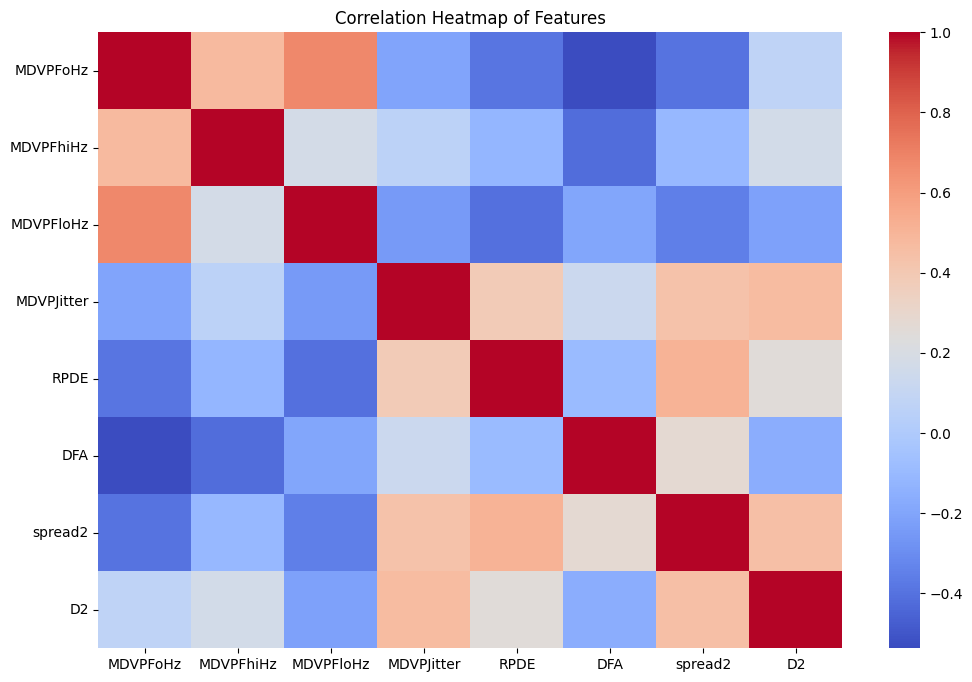

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X_resampled.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()

**Applied the Interaction technique to make feature dynamic.**

In [ ]:
# Interaction features for top 6 features
rf_initial = RandomForestClassifier(random_state=42).fit(X_resampled, y_resampled)
importance = pd.Series(rf_initial.feature_importances_, index=X_resampled.columns).sort_values(ascending=False)
top_features = importance.head(6).index.tolist()
X_top = X_resampled[top_features]
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_top)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_top.columns))
X_resampled = pd.concat([X_resampled, X_poly], axis=1)
print(f"Features after interaction terms: {X_resampled.shape[1]}")

Features after interaction terms: 29


**PCA-Principle Component Analysis**

In [ ]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_resampled)
print(f"Number of PCA components: {X_pca.shape[1]}")

Number of PCA components: 14


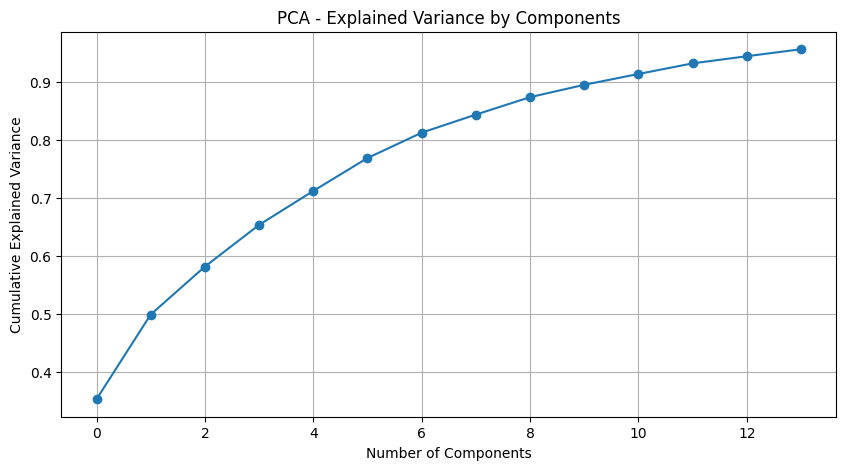

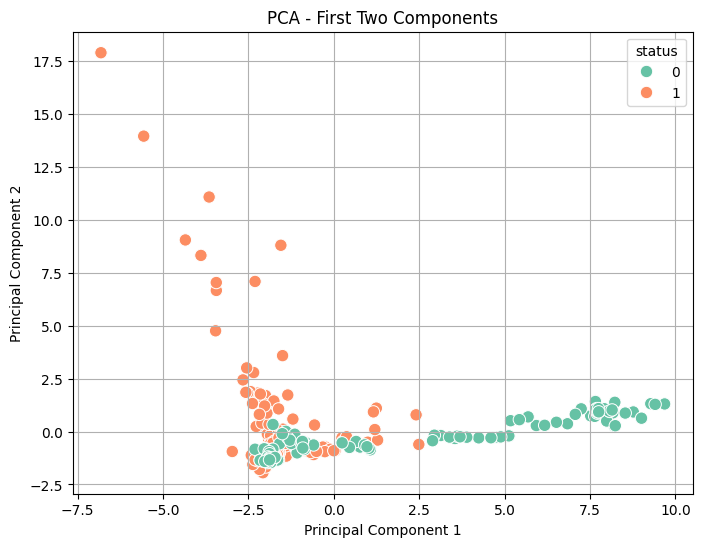

In [ ]:
# PCA visualizations
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance by Components')
plt.grid(True)
plt.show()

if X_pca.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_resampled, palette='Set2', s=80)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA - First Two Components')
    plt.grid(True)
    plt.show()

**Data Augmentation to increase the number of data samples.**

In [ ]:
# [Step 4] Data Augmentation
# Gaussian noise
noise = np.random.normal(0, 0.05, X_resampled.shape)
X_augmented = X_resampled + noise
y_augmented = y_resampled.copy()

**Tried to applied CTGAN/Gaussian Augmentation with the condition if CTGAN fails fall back to gaussian only.**

*CTGAN-Conditional Tabular Generative Adversarial Network which is a GAN-based data synthesizer used to generate synthetic tabular data. It learns from real data and produces synthetic data with high fidelity, mimicking the statistical properties of the original dataset. CTGAN is particularly well-suited for handling heterogeneous tabular data with both numeric and categorical features.*

*Gaussian noise augmentation is a data augmentation technique where random Gaussian noise is added to training data, like images or signals, to make models more robust and generalize better to noisy real-world scenarios. By introducing noise, the model learns to focus on essential features and becomes less sensitive to minor variations, improving its performance on unseen data.*

In [ ]:
# CTGAN for synthetic samples
try:
    # Ensure y_resampled is a DataFrame with a named column
    y_resampled_df = pd.DataFrame(y_resampled, columns=['status'])
    data_for_ctgan = pd.concat([X_resampled, y_resampled_df], axis=1)

    # Explicitly define metadata
    metadata = SingleTableMetadata()
    metadata_dict = {
        'columns': {col: {'sdtype': 'numerical'} for col in X_resampled.columns},
        'primary_key': None
    }
    metadata_dict['columns']['status'] = {'sdtype': 'categorical'}
    metadata._load_from_dict(metadata_dict)

    # Fit CTGAN
    synthesizer = CTGANSynthesizer(metadata)
    synthesizer.fit(data_for_ctgan)
    synthetic_data = synthesizer.sample(100)
    X_synthetic = synthetic_data.drop('status', axis=1)
    y_synthetic = synthetic_data['status']
except Exception as e:
    print(f"CTGAN failed: {e}. Falling back to Gaussian noise augmentation only.")
    X_synthetic = X_augmented.copy()
    y_synthetic = y_augmented.copy()

CTGAN failed: 'SingleTableMetadata' object has no attribute '_load_from_dict'. Falling back to Gaussian noise augmentation only.


**Combining the Augmented Data. Final Dataset Shape (792, 29).**

In [ ]:
# Combine augmented data
X_final = pd.concat([X_resampled, X_augmented, X_synthetic], axis=0).reset_index(drop=True)
y_final = pd.concat([y_resampled, y_augmented, y_synthetic], axis=0).reset_index(drop=True)
print(f"Final dataset shape: {X_final.shape}")

Final dataset shape: (792, 29)


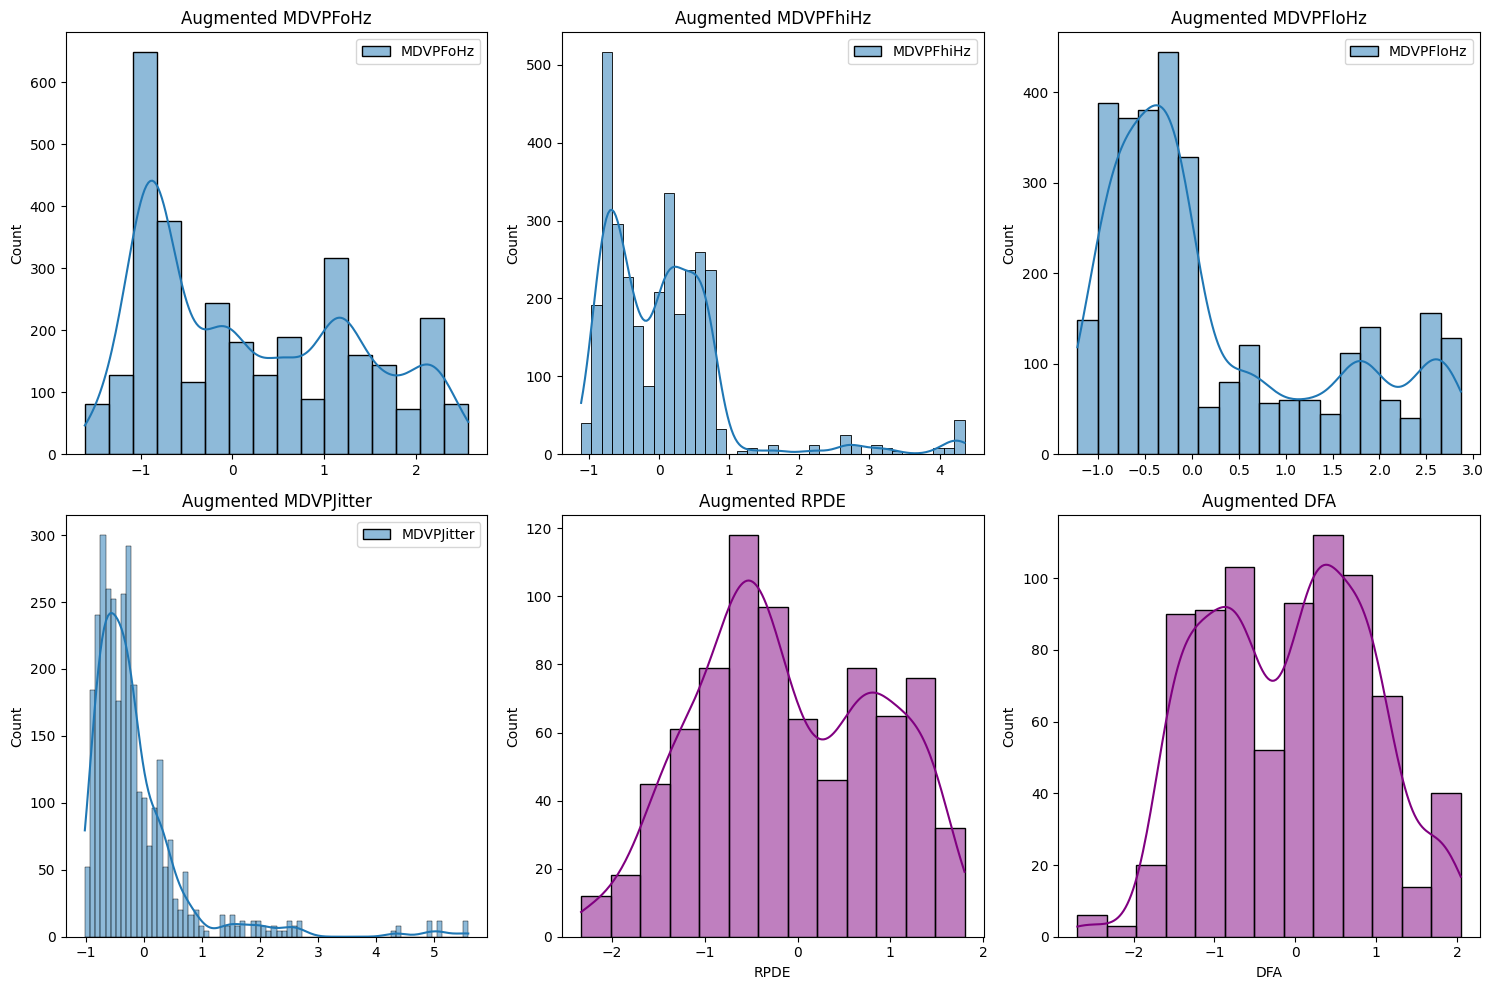

In [ ]:
# Visualize augmented data
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_final.columns[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(X_final[col], kde=True, color='purple')
    plt.title(f'Augmented {col}')
plt.tight_layout()
plt.show()

**Traning the Models**

In [ ]:
# [Step 5] Model Training
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = y_train.reset_index(drop=True)  # Reset indices
y_test = y_test.reset_index(drop=True)    # Reset indices

**Three Pre-Trained Models:**


1.   RestNet50
2.   VGG16
3.   MobileNetV2


**Seven Traditonal Models:**


1. LogisticRegression

2. RandomForest

3. Support Vector Machine (SVM)

4. KNN

5. XGBoost

6. AdaBoost

7. GradientBoosting


**Soft Voting Ensembel of 7 Traditional Models (pre-trained models excluded).**

In [ ]:
# Prepare data for pre-trained models (reshape to 2D)
def reshape_for_cnn(X, target_size=(32, 32)):
    n_features = X.shape[1]
    side = int(np.ceil(np.sqrt(n_features)))
    X_reshaped = np.zeros((X.shape[0], target_size[0], target_size[1], 1))
    for i in range(X.shape[0]):
        padded = np.zeros((side, side))
        flat = X[i, :side*side]
        padded.flat[:len(flat)] = flat
        padded = np.pad(padded, ((0, target_size[0]-side), (0, target_size[1]-side)), mode='constant')
        X_reshaped[i, :, :, 0] = padded
    return X_reshaped

X_train_cnn = reshape_for_cnn(X_train_scaled)
X_test_cnn = reshape_for_cnn(X_test_scaled)

# Define pre-trained models
def build_cnn_model(base_model, input_shape=(32, 32, 1)):
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Duplicate single-channel input for pre-trained models
X_train_cnn_3ch = np.repeat(X_train_cnn, 3, axis=-1)
X_test_cnn_3ch = np.repeat(X_test_cnn, 3, axis=-1)

resnet_model = build_cnn_model(resnet_base)
vgg_model = build_cnn_model(vgg_base)
mobilenet_model = build_cnn_model(mobilenet_base)

# Train pre-trained models
resnet_model.fit(X_train_cnn_3ch, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
vgg_model.fit(X_train_cnn_3ch, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
mobilenet_model.fit(X_train_cnn_3ch, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define traditional models and parameter grids
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, penalty='l2'),
        'params': {'C': [0.1, 0.5, 1.0, 5.0], 'solver': ['liblinear', 'lbfgs']}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [5, 10, 20, 50, 100], 'kernel': ['rbf', 'linear'], 'gamma': [0.001, 0.005, 0.01]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42),
        'params': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'min_child_weight': [1, 3], 'reg_lambda': [0.1, 1.0]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.6, 0.8, 1.0]}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1, 1.0]}
    }
}

In [ ]:
# Tune traditional models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
cv_results = []
for name, mp in model_params.items():
    print(f"Tuning {name}...")
    clf = RandomizedSearchCV(mp['model'], mp['params'], n_iter=30, cv=skf, scoring='f1', n_jobs=-1, random_state=42)
    clf.fit(X_train_scaled, y_train)
    best_models[name] = clf.best_estimator_
    print(f"Best params for {name}: {clf.best_params_}")
    cv_scores = cross_val_score(clf.best_estimator_, X_train_scaled, y_train, cv=skf, scoring='f1')
    cv_results.append({'Model': name, 'CV F1-Score Mean': cv_scores.mean(), 'CV F1-Score Std': cv_scores.std()})


Tuning LogisticRegression...
Best params for LogisticRegression: {'solver': 'liblinear', 'C': 1.0}
Tuning SVM...
Best params for SVM: {'kernel': 'rbf', 'gamma': 0.01, 'C': 100}
Tuning RandomForest...
Best params for RandomForest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Tuning KNN...
Best params for KNN: {'weights': 'distance', 'p': 1, 'n_neighbors': 3}
Tuning XGBoost...
Best params for XGBoost: {'subsample': 1.0, 'reg_lambda': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Tuning GradientBoosting...
Best params for GradientBoosting: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}
Tuning AdaBoost...
Best params for AdaBoost: {'n_estimators': 300, 'learning_rate': 1.0}


In [ ]:
# [Step 6] Ensemble
# Wrap CNN models for scikit-learn compatibility
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.fit(X, y, epochs=15, batch_size=32, verbose=0)
        return self
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int).flatten()
    def predict_proba(self, X):
        probs = self.model.predict(X)
        return np.hstack([(1-probs), probs])

best_models['ResNet50'] = KerasClassifierWrapper(resnet_model)
best_models['VGG16'] = KerasClassifierWrapper(vgg_model)
best_models['MobileNetV2'] = KerasClassifierWrapper(mobilenet_model)

In [ ]:
# Soft voting ensemble (traditional models only)
estimators = [(name, model) for name, model in best_models.items() if name not in ['ResNet50', 'VGG16', 'MobileNetV2']]
voting = VotingClassifier(estimators=estimators, voting='soft')
voting.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('LogisticRegression',
                              LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='liblinear')),
                             ('SVM',
                              SVC(C=100, gamma=0.01, probability=True,
                                  random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=20,
                                                     max_features='log2',
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('KNN',
                              KNeighborsClassifier(n_neighbors=3, p=1,
                                                   weights='dist...
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         n_estimators=300,
                                                         random_state=42)),
                             ('AdaBoost',
                              AdaBoostClassifier(n_estimators=300,
                                                 random_state=42))],
                 voting='soft')

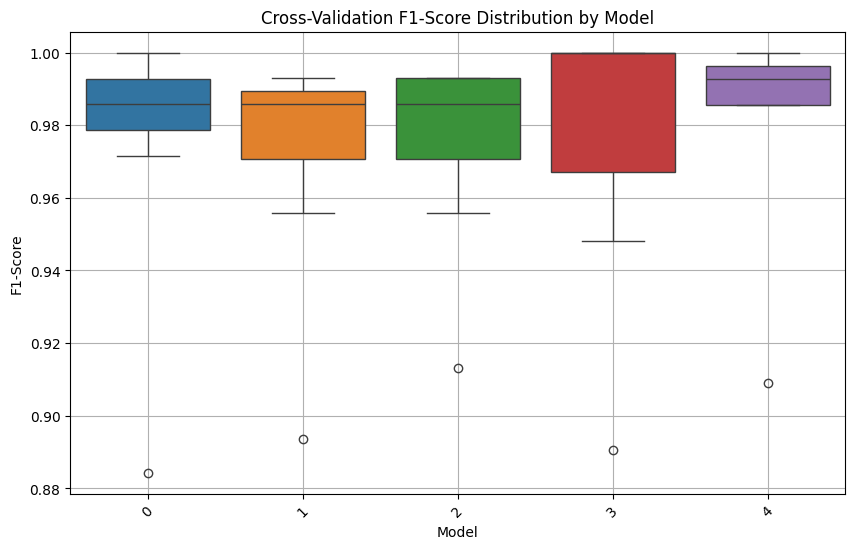

In [ ]:
# [Step 7] Evaluation and Visualization
# Cross-validation box plot
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame({row['Model']: cross_val_score(best_models[row['Model']], X_train_scaled, y_train, cv=skf, scoring='f1') for row in cv_results}).T)
plt.title('Cross-Validation F1-Score Distribution by Model')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

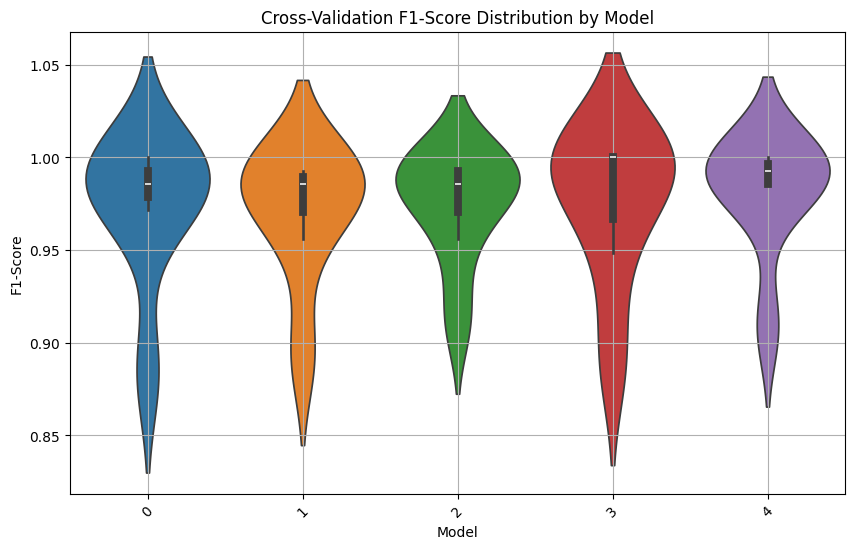

In [ ]:
# Cross-validation violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=pd.DataFrame({row['Model']: cross_val_score(best_models[row['Model']], X_train_scaled, y_train, cv=skf, scoring='f1') for row in cv_results}).T) # Removed the invalid phrase
plt.title('Cross-Validation F1-Score Distribution by Model')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

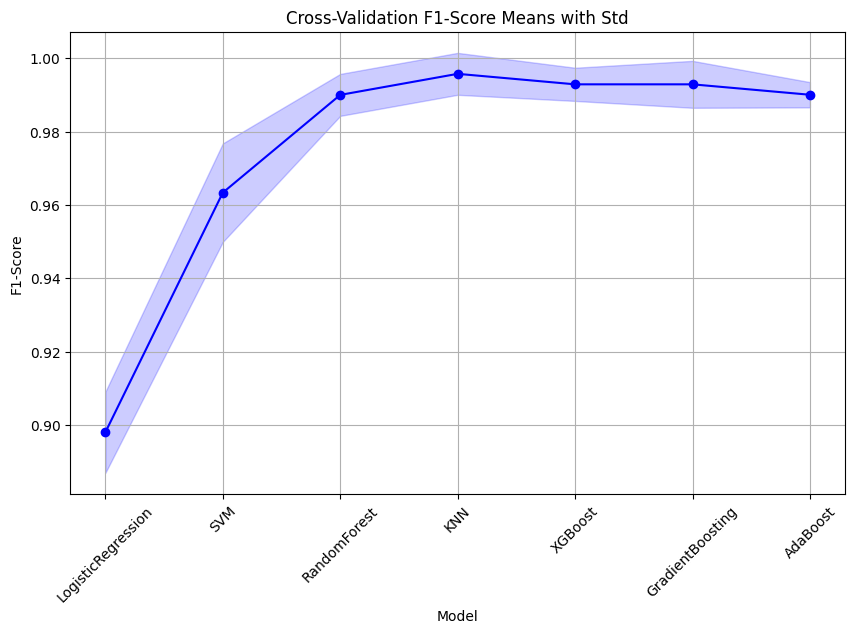

In [ ]:
# Line chart for CV F1-Score means
plt.figure(figsize=(10, 6))
plt.plot(cv_df['Model'], cv_df['CV F1-Score Mean'], marker='o', color='b')
plt.fill_between(cv_df['Model'], cv_df['CV F1-Score Mean'] - cv_df['CV F1-Score Std'], cv_df['CV F1-Score Mean'] + cv_df['CV F1-Score Std'], alpha=0.2, color='b')
plt.title('Cross-Validation F1-Score Means with Std')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Evaluate models
metrics = []
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    start = time.time()
    if name in ['ResNet50', 'VGG16', 'MobileNetV2']:
        y_pred = model.predict(X_test_cnn_3ch)
        y_prob = model.predict_proba(X_test_cnn_3ch)[:, 1]
    else:
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    inference_time = time.time() - start

    acc_ci = bootstrap_ci(y_test, y_pred, accuracy_score)
    f1_ci = bootstrap_ci(y_test, y_pred, f1_score)

    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Accuracy CI': f"{acc_ci[0]:.4f}-{acc_ci[1]:.4f}",
        'AUC-ROC': roc_auc_score(y_test, y_prob),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'F1-Score CI': f"{f1_ci[0]:.4f}-{f1_ci[1]:.4f}",
        'Inference Time (s)': inference_time
    })

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 659ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


<Figure size 1000x800 with 0 Axes>

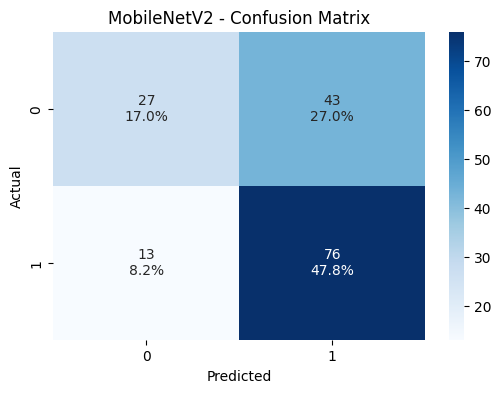

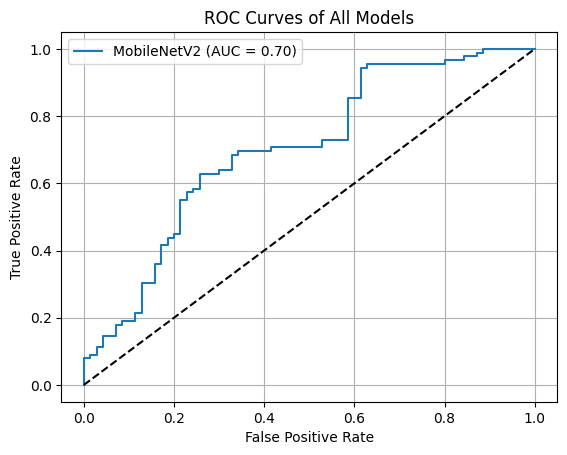

In [ ]:
    # Confusion matrix with percentages
    cm = confusion_matrix(y_test, y_pred)
    cm_percentage = cm / cm.sum() * 100
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=np.array([f"{val}\n{perc:.1f}%" for val, perc in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape), fmt='', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of All Models')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate voting ensemble
y_pred_voting = voting.predict(X_test_scaled)
y_prob_voting = voting.predict_proba(X_test_scaled)[:, 1]
acc_ci_voting = bootstrap_ci(y_test, y_pred_voting, accuracy_score)
f1_ci_voting = bootstrap_ci(y_test, y_pred_voting, f1_score)

metrics_df = pd.DataFrame(metrics)
metrics_df = pd.concat([metrics_df, pd.DataFrame([{
    'Model': 'Soft Voting Ensemble',
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Accuracy CI': f"{acc_ci_voting[0]:.4f}-{acc_ci_voting[1]:.4f}",
    'AUC-ROC': roc_auc_score(y_test, y_prob_voting),
    'Precision': precision_score(y_test, y_pred_voting),
    'Recall': recall_score(y_test, y_pred_voting),
    'F1-Score': f1_score(y_test, y_pred_voting),
    'F1-Score CI': f"{f1_ci_voting[0]:.4f}-{f1_ci_voting[1]:.4f}",
    'Inference Time (s)': time.time() - start
}])], ignore_index=True)

In [ ]:
# McNemar's test for SVM vs. Soft Voting
svm_pred = best_models['SVM'].predict(X_test_scaled)
p_value = manual_mcnemar(y_test, svm_pred, y_pred_voting)
print(f"Manual McNemar's Test (SVM vs. Soft Voting): p-value = {p_value:.4f}")

Manual McNemar's Test (SVM vs. Soft Voting): p-value = 1.0000


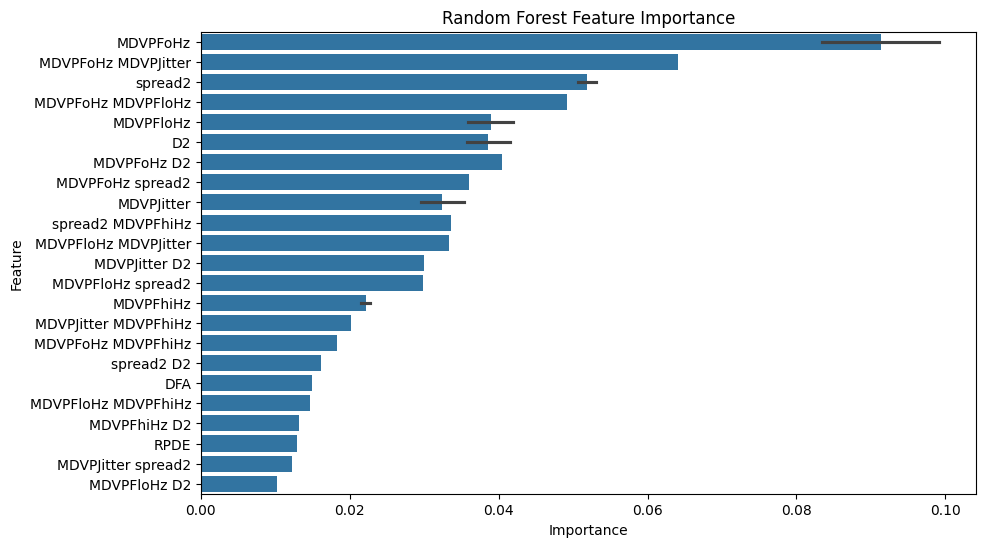

In [ ]:
# Feature importance (Random Forest)
rf_model = best_models['RandomForest']
feature_importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

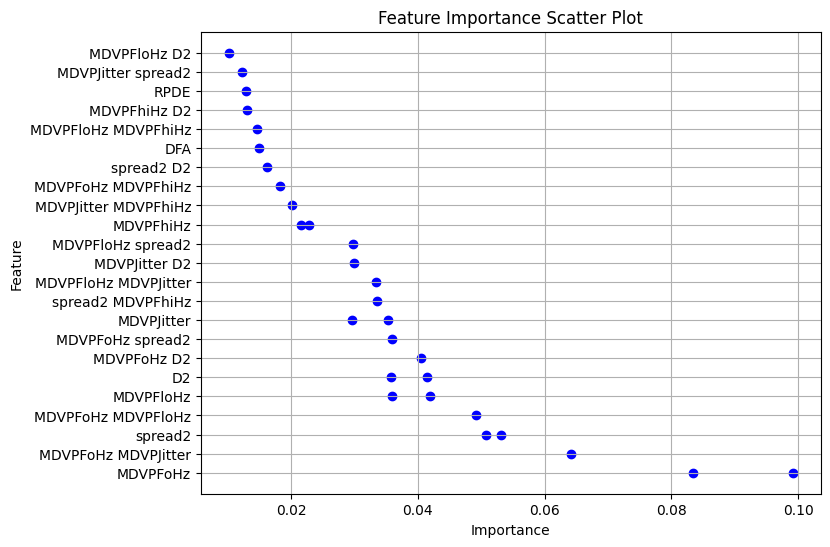

In [ ]:
# Scatter plot of feature importance
plt.figure(figsize=(8, 6))
plt.scatter(feature_importance['Importance'], feature_importance['Feature'], color='b')
plt.title('Feature Importance Scatter Plot')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

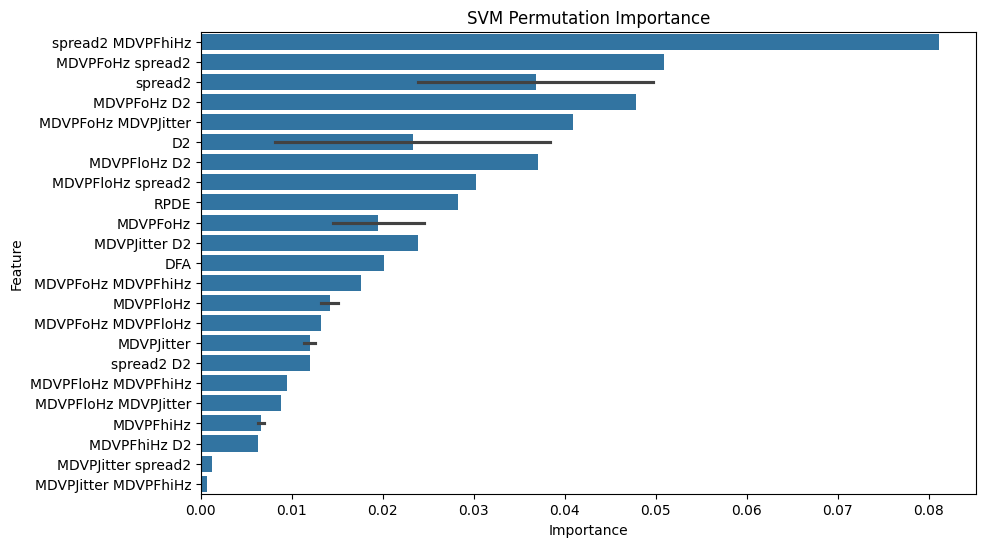

In [ ]:
# Permutation importance for SVM
perm_importance = permutation_importance(best_models['SVM'], X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_df)
plt.title('SVM Permutation Importance')
plt.show()

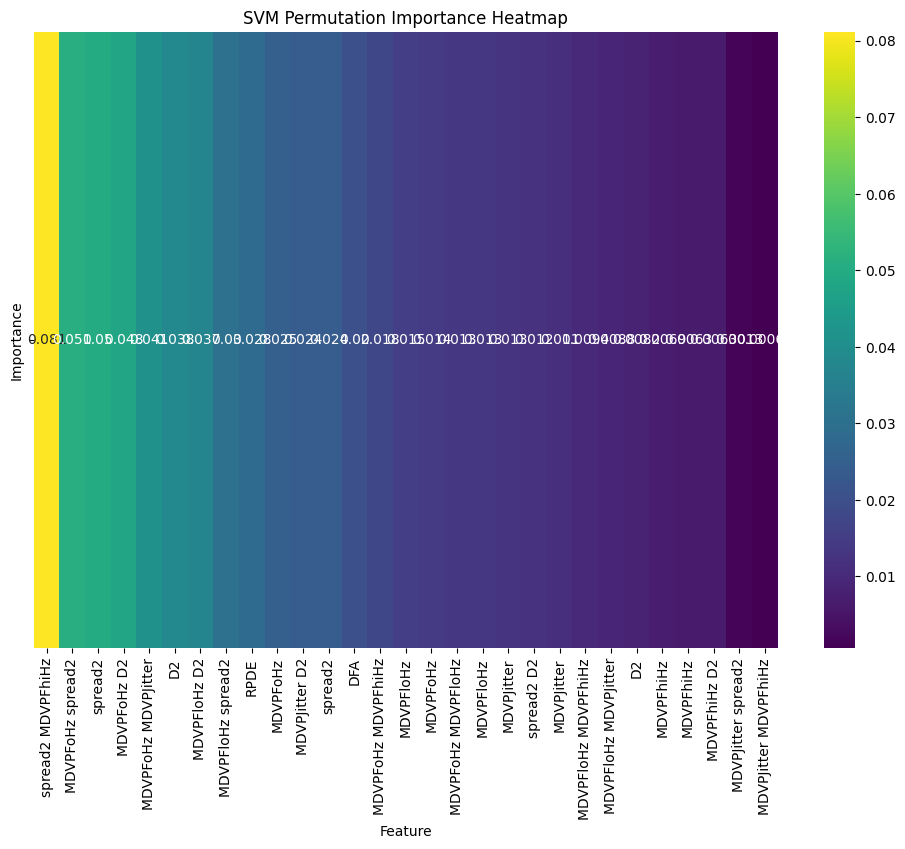

In [ ]:
# Feature importance heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(perm_df.set_index('Feature')[['Importance']].T, annot=True, cmap='viridis')
plt.title('SVM Permutation Importance Heatmap')
plt.show()

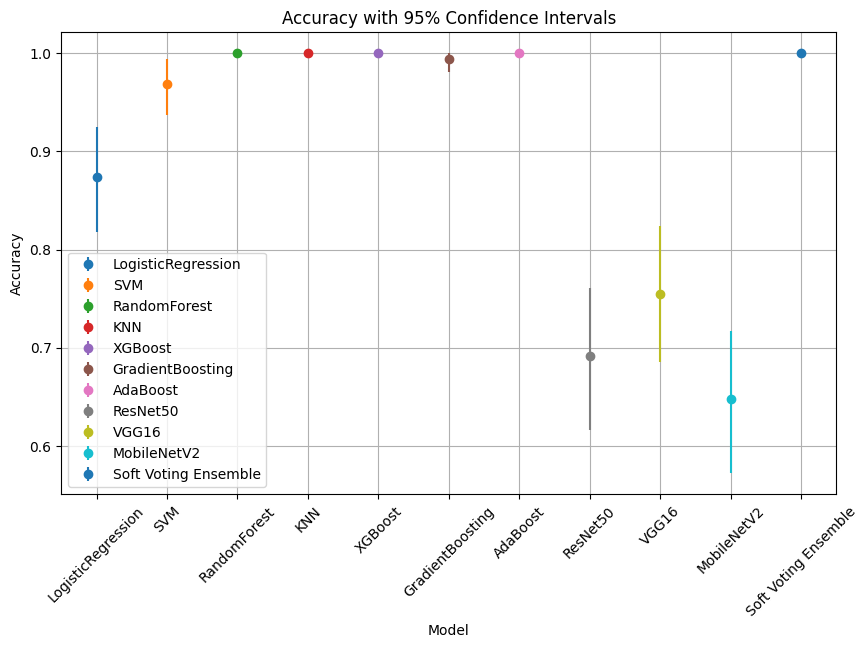

In [ ]:
# Bootstrap CI plot
plt.figure(figsize=(10, 6))
for i, row in metrics_df.iterrows():
    # Calculate error bar lengths for compatibility with plt.errorbar
    lower_err = row['Accuracy'] - float(row['Accuracy CI'].split('-')[0])
    upper_err = float(row['Accuracy CI'].split('-')[1]) - row['Accuracy']
    # Use a list for yerr with a single value to match the shape of y
    plt.errorbar(i, row['Accuracy'], yerr=[[lower_err], [upper_err]], fmt='o', label=row['Model'])
plt.title('Accuracy with 95% Confidence Intervals')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(range(len(metrics_df)), metrics_df['Model'], rotation=45)
plt.legend()
plt.grid(True)
plt.show()

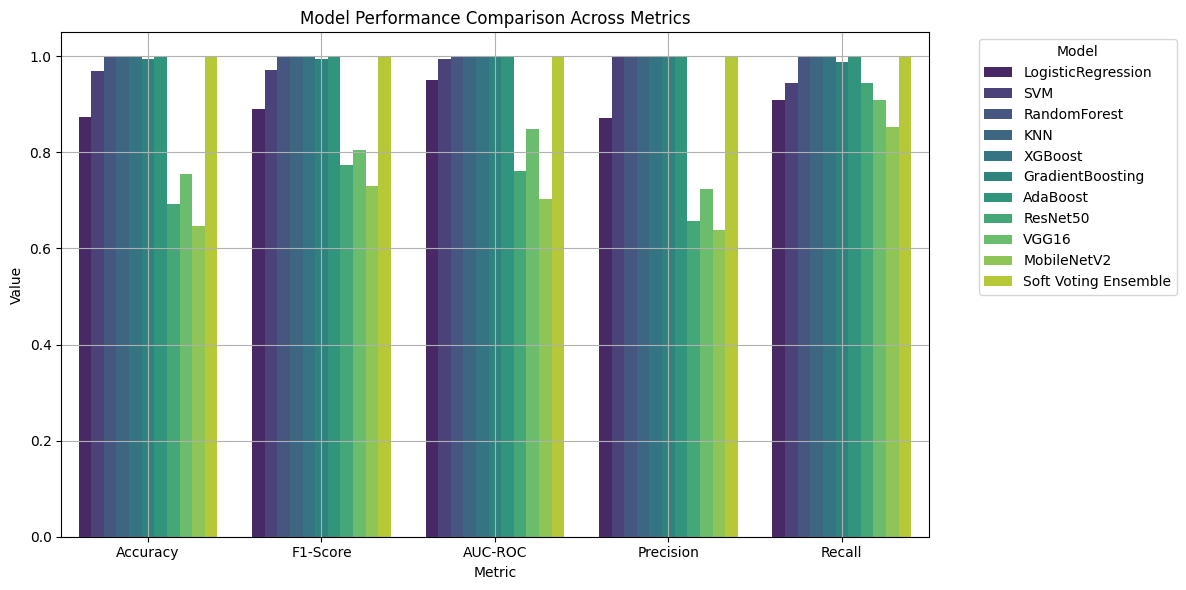

In [ ]:
# Bar plot for model comparison
plt.figure(figsize=(12, 6))
metrics_melted = metrics_df.melt(id_vars='Model', value_vars=['Accuracy', 'F1-Score', 'AUC-ROC', 'Precision', 'Recall'], var_name='Metric', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted, palette='viridis')
plt.title('Model Performance Comparison Across Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

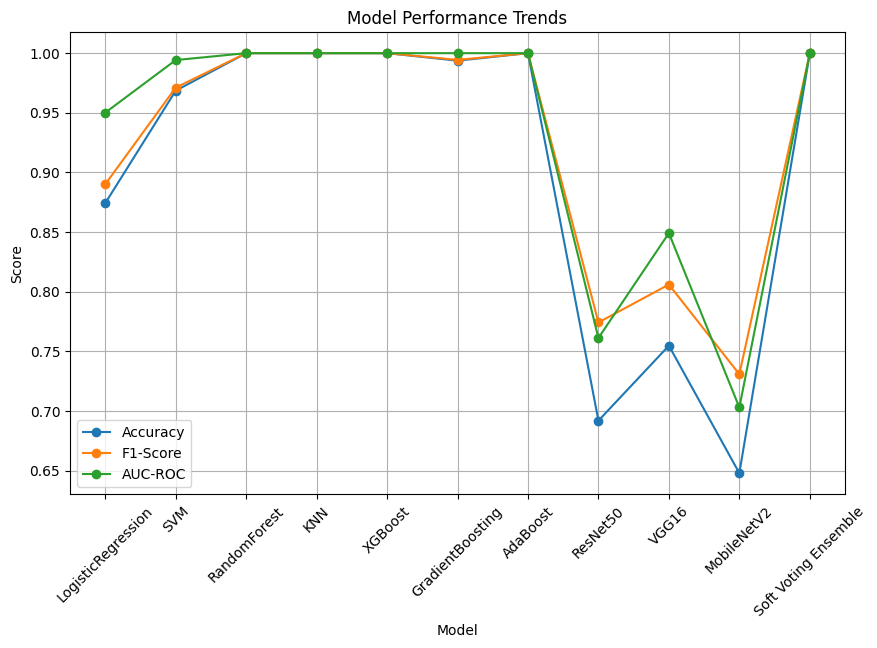

In [ ]:
# Line plot for model comparison
plt.figure(figsize=(10, 6))
for metric in ['Accuracy', 'F1-Score', 'AUC-ROC']:
    plt.plot(metrics_df['Model'], metrics_df[metric], marker='o', label=metric)
plt.title('Model Performance Trends')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

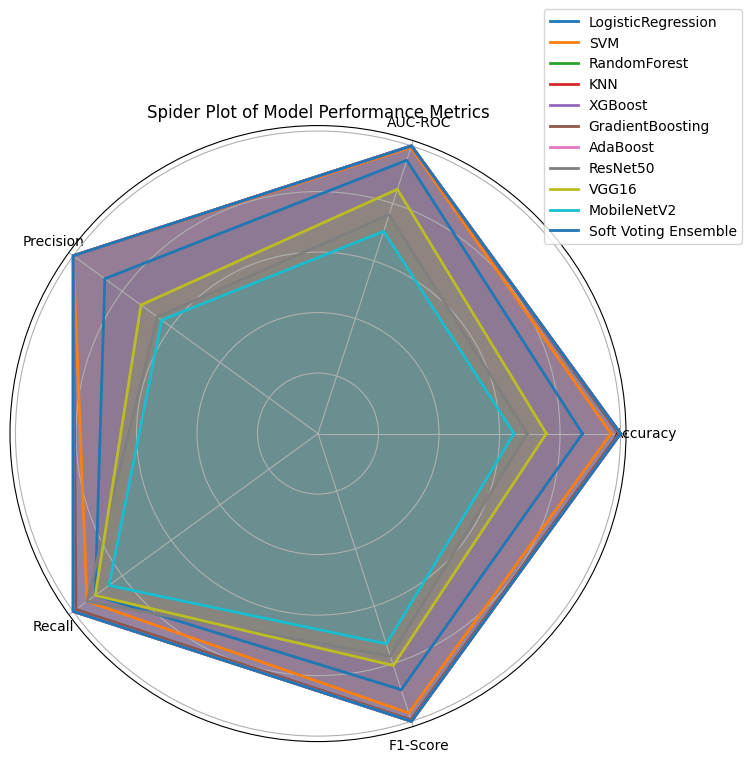

In [ ]:
# Spider chart
def plot_spider_chart(df):
    labels = ['Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for _, row in df.iterrows():
        values = row[labels].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Model'])
        ax.fill(angles, values, alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title('Spider Plot of Model Performance Metrics')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
    plt.show()

plot_spider_chart(metrics_df)

In [ ]:
# Display results
print("\nCross-Validation Results:")
print(cv_df)
print("\nTest Set Results:")
print(metrics_df)


Cross-Validation Results:
                Model  CV F1-Score Mean  CV F1-Score Std
0  LogisticRegression          0.898123         0.011052
1                 SVM          0.963370         0.013408
2        RandomForest          0.989990         0.005709
3                 KNN          0.995724         0.005709
4             XGBoost          0.992867         0.004518
5    GradientBoosting          0.992867         0.006389
6            AdaBoost          0.990030         0.003442

Test Set Results:
                   Model  Accuracy    Accuracy CI   AUC-ROC  Precision  \
0     LogisticRegression  0.874214  0.8176-0.9245  0.950080   0.870968   
1                    SVM  0.968553  0.9371-0.9937  0.994222   1.000000   
2           RandomForest  1.000000  1.0000-1.0000  1.000000   1.000000   
3                    KNN  1.000000  1.0000-1.0000  1.000000   1.000000   
4                XGBoost  1.000000  1.0000-1.0000  1.000000   1.000000   
5       GradientBoosting  0.993711  0.9811-1.0000  1.0

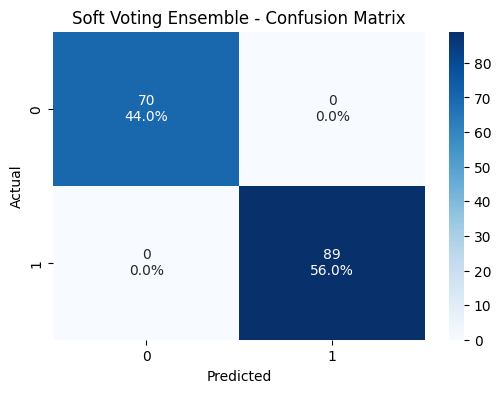

In [ ]:
# prompt: Confusion Matrix of Soft Voting Ensemble

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_voting are defined from your code
# Example:
# y_test = ... # Your true labels
# y_pred_voting = voting.predict(X_test_scaled) # Your predicted labels

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm / cm.sum() * 100
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=np.array([f"{val}\n{perc:.1f}%" for val, perc in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape), fmt='', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


plot_confusion_matrix(y_test, y_pred_voting, "Soft Voting Ensemble - Confusion Matrix")


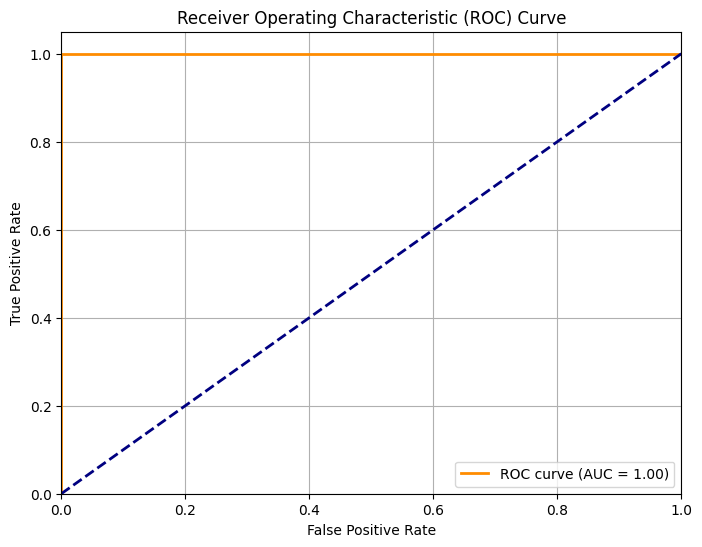

In [ ]:
# prompt: ROC Curve of Soft Voting Ensemble

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_test and y_prob_voting are defined from your code
# Example:
# y_test = ... # Your true labels
# y_prob_voting = voting.predict_proba(X_test_scaled)[:, 1] # Your predicted probabilities

fpr, tpr, thresholds = roc_curve(y_test, y_prob_voting)
roc_auc = roc_auc_score(y_test, y_prob_voting)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


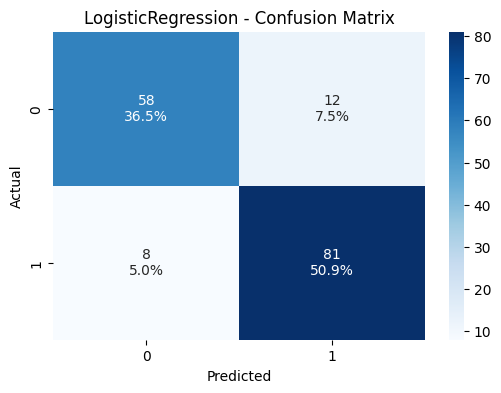

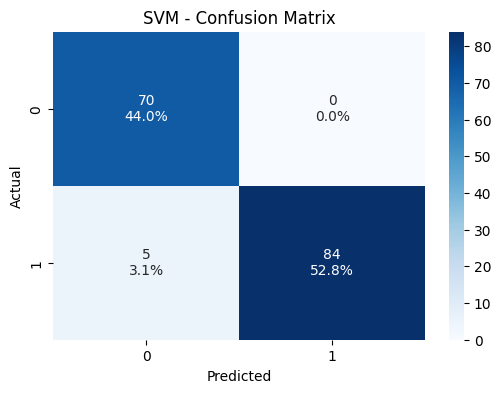

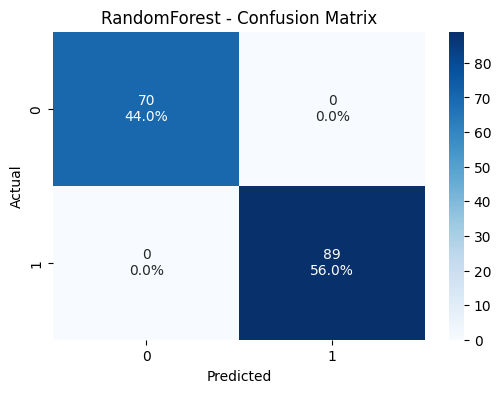

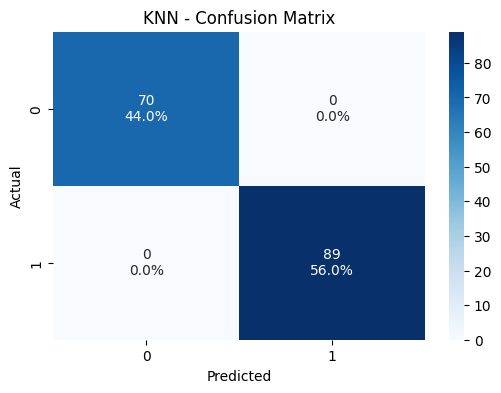

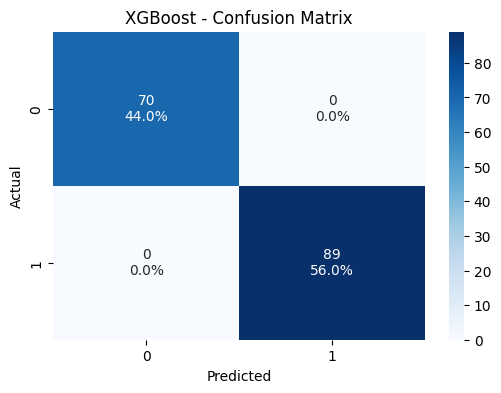

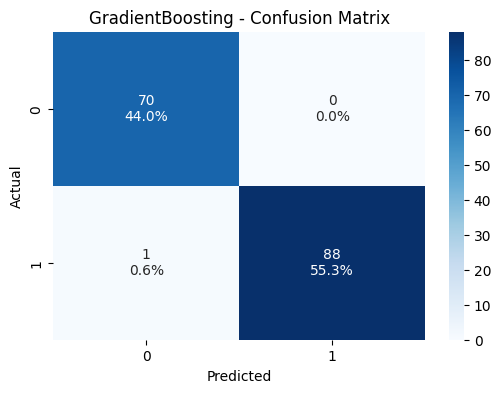

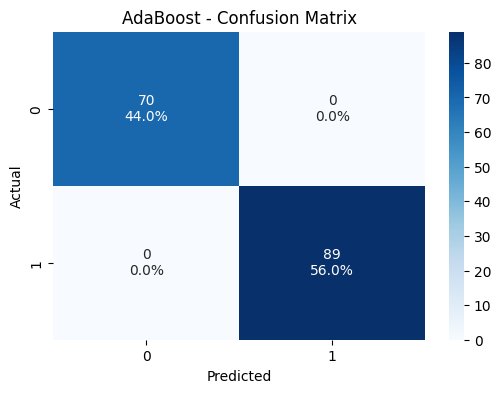

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


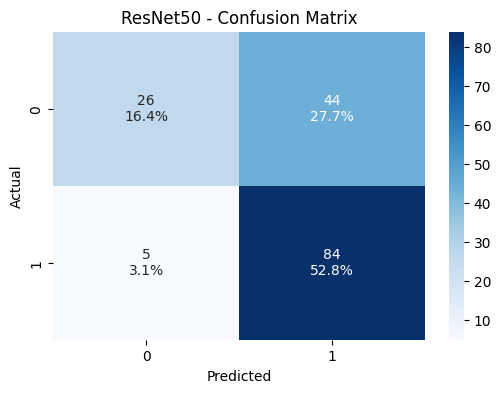

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step


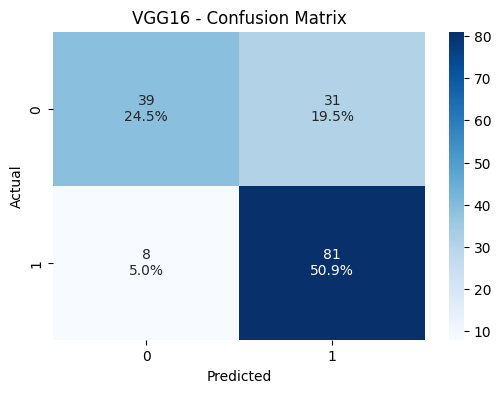

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


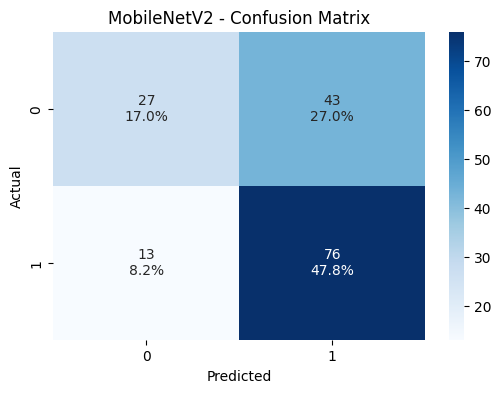

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



models_to_exclude = ['Soft Voting Ensemble']

for name, model in best_models.items():
    if name not in models_to_exclude:
        if name in ['ResNet50', 'VGG16', 'MobileNetV2']:
            y_pred = model.predict(X_test_cnn_3ch)
        else:
            y_pred = model.predict(X_test_scaled)

        cm = confusion_matrix(y_test, y_pred)
        cm_percentage = cm / cm.sum() * 100
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=np.array([f"{val}\n{perc:.1f}%" for val, perc in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape), fmt='', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


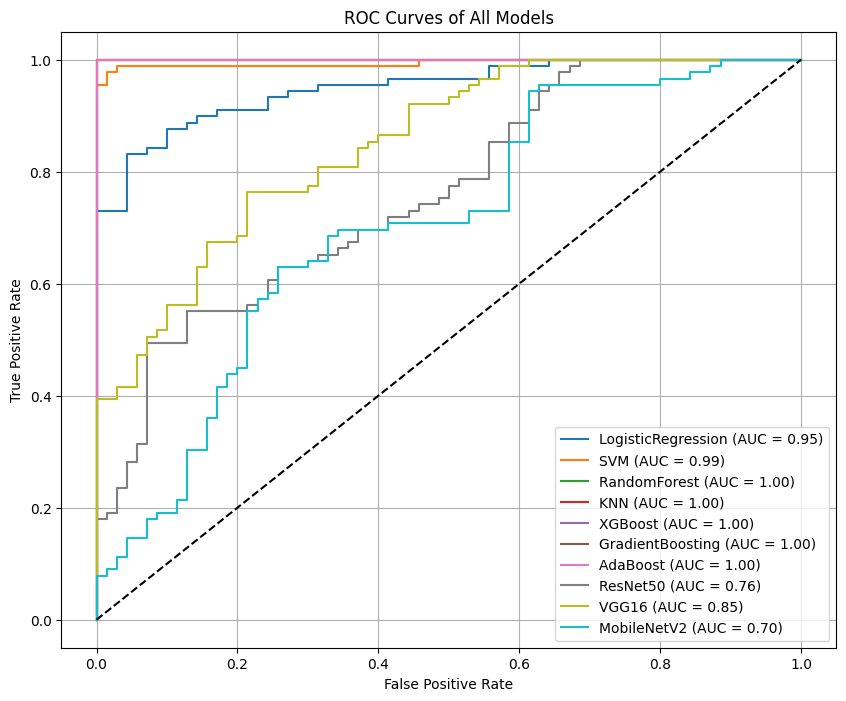

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


models_to_include = ['Soft Voting Ensemble', 'LogisticRegression', 'SVM', 'RandomForest', 'KNN', 'XGBoost', 'GradientBoosting', 'AdaBoost', 'ResNet50', 'VGG16', 'MobileNetV2']

plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    if name in models_to_include:
        if name in ['ResNet50', 'VGG16', 'MobileNetV2']:
            y_prob = model.predict_proba(X_test_cnn_3ch)[:, 1]
        else:
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of All Models')
plt.legend()
plt.grid(True)
plt.show()


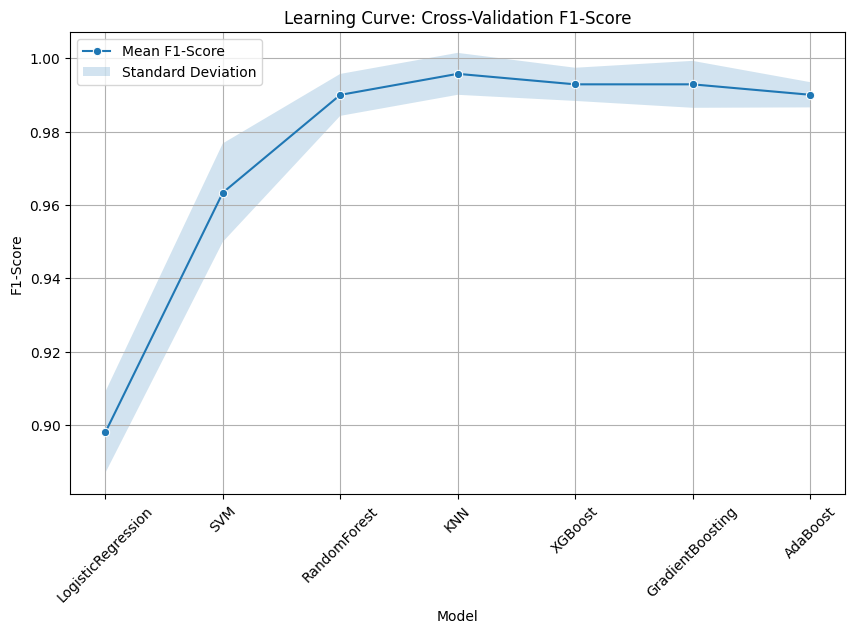

In [ ]:
# prompt: Learning Curve of all the models

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'cv_results' and 'best_models' are defined from your previous code

# Cross-validation learning curve
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.lineplot(x='Model', y='CV F1-Score Mean', data=cv_df, marker='o', label='Mean F1-Score')
plt.fill_between(cv_df['Model'], cv_df['CV F1-Score Mean'] - cv_df['CV F1-Score Std'], cv_df['CV F1-Score Mean'] + cv_df['CV F1-Score Std'], alpha=0.2, label='Standard Deviation')
plt.title('Learning Curve: Cross-Validation F1-Score')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 849ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


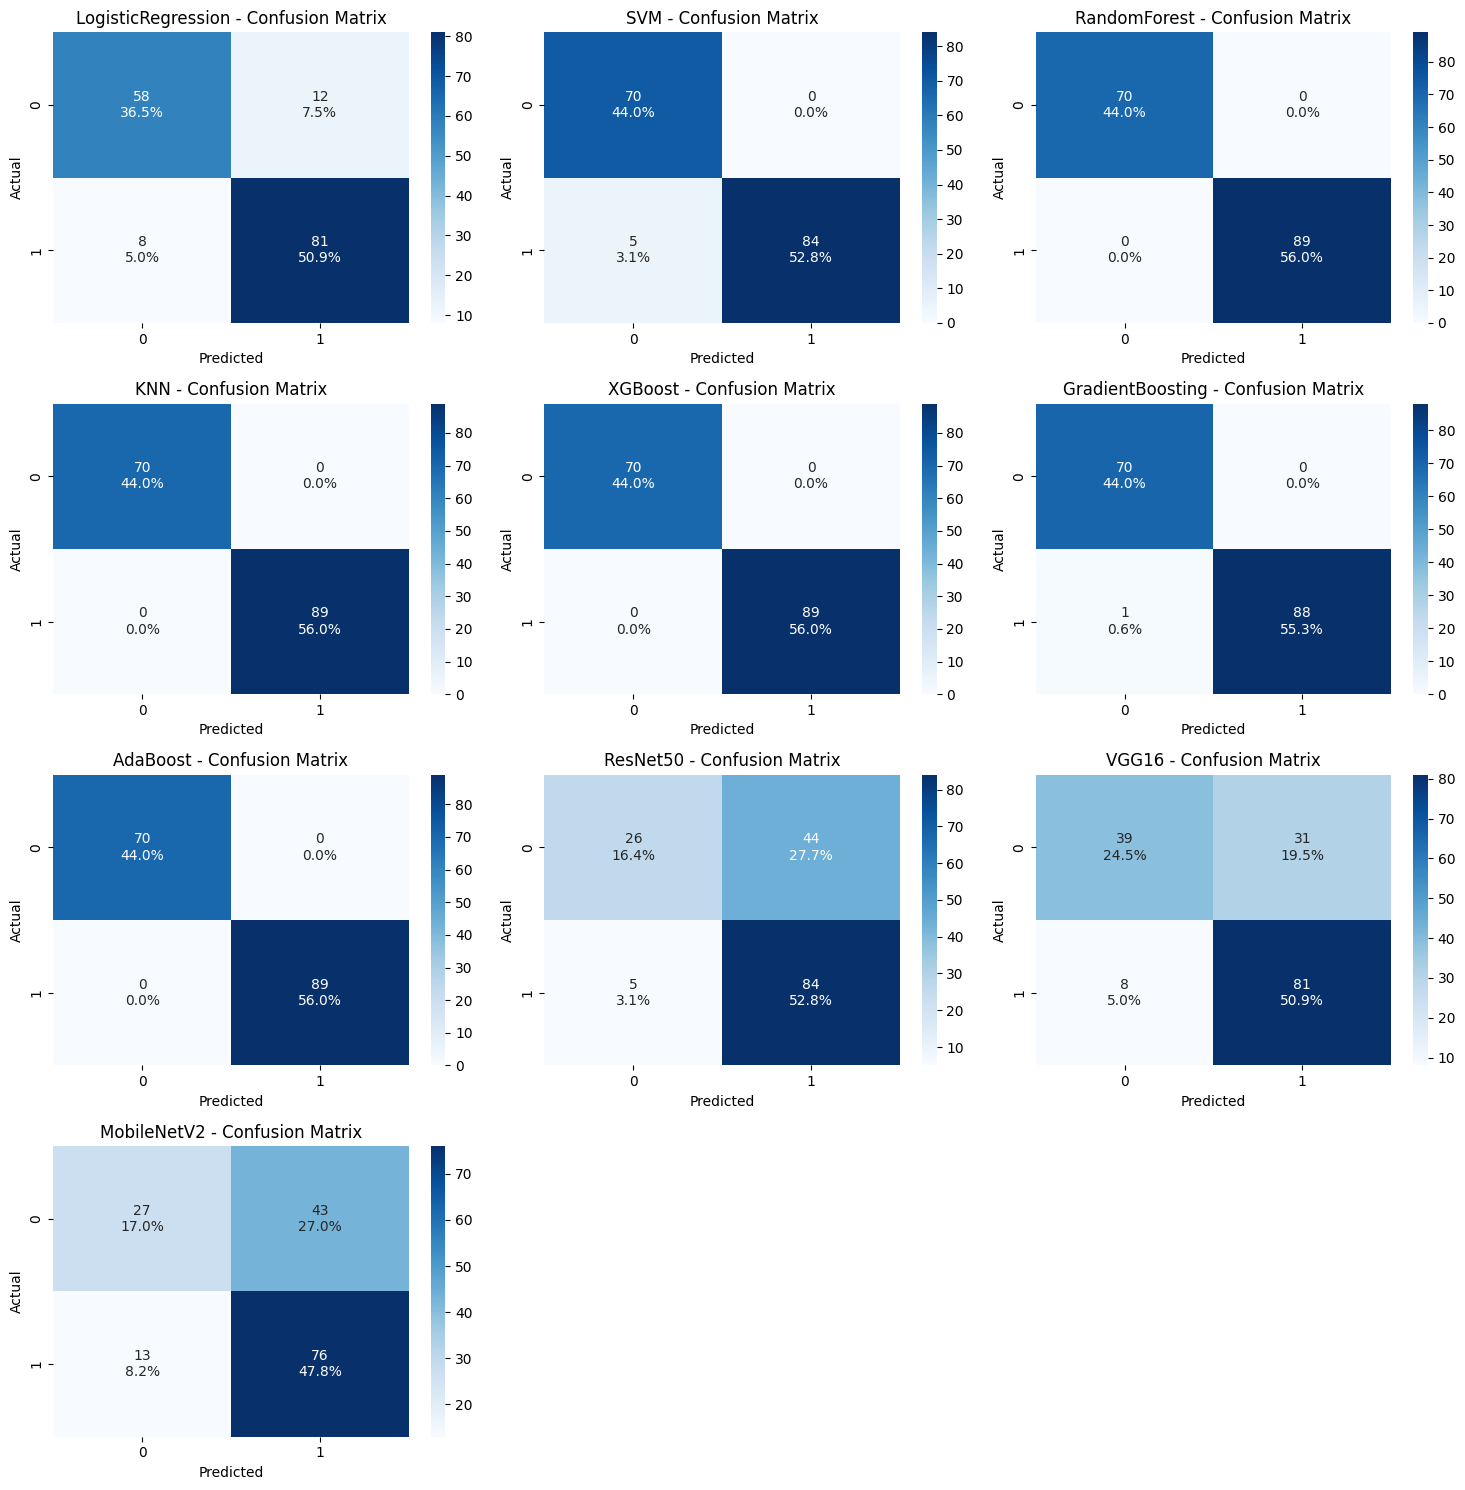

In [ ]:
# prompt: Combine the Confusion Matrix of all the models in one frame.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm / cm.sum() * 100
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=np.array([f"{val}\n{perc:.1f}%" for val, perc in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape), fmt='', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming you have a dictionary 'best_models' with your trained models and y_test
# Example:
# best_models = {'model1': model1, 'model2': model2, ...}


# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))  # Adjust the number of rows and columns as needed
axes = axes.flatten() # Flatten the array of axes for easy iteration

for i, (name, model) in enumerate(best_models.items()):
  if i < len(axes):
      ax = axes[i]
      if name in ['ResNet50', 'VGG16', 'MobileNetV2']:
          y_pred = model.predict(X_test_cnn_3ch)
      else:
          y_pred = model.predict(X_test_scaled)

      cm = confusion_matrix(y_test, y_pred)
      cm_percentage = cm / cm.sum() * 100
      sns.heatmap(cm, annot=np.array([f"{val}\n{perc:.1f}%" for val, perc in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape), fmt='', cmap='Blues', ax=ax)
      ax.set_title(f'{name} - Confusion Matrix')
      ax.set_xlabel('Predicted')
      ax.set_ylabel('Actual')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])


plt.tight_layout()
plt.show()
